In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from tqdm import tqdm
from collections import OrderedDict
import time
import sklearn.datasets
import umap
import umap.plot

In [2]:
train = datasets.MNIST("../data/", train=True, download=True, transform=transforms.ToTensor())
test = datasets.MNIST("../data/", train=False, download=True, transform=transforms.ToTensor())

In [36]:
IM_SIZE = 28 * 28
IM_SHAPE = (28, 28)
CPU_training = False
BATCH = 64
EPOCHS = 50

use_cuda =  torch.cuda.is_available() and not CPU_training
device = torch.device("cuda" if use_cuda else "cpu")

trainset = torch.utils.data.DataLoader(train, batch_size=BATCH, shuffle=True, num_workers=6, pin_memory=use_cuda)
testset = torch.utils.data.DataLoader(test, batch_size=BATCH, shuffle=True, num_workers=6, pin_memory=use_cuda)

TypeError: object of type 'function' has no len()

In [16]:
class PCA(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.encoder = nn.Sequential(
            nn.Dropout2d(0.5),
            nn.Linear(IM_SIZE, dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(dim, IM_SIZE),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
class AutoEncoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.encoder = nn.Sequential(
            nn.Dropout2d(0.5),
            nn.Linear(IM_SIZE, 64),
            nn.ReLU(True),
            nn.Linear(64, dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(True),
            nn.Linear(64, IM_SIZE),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.decoder(self.encoder(x))

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

class AutoEncoderConv(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(True)
        )
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(True)
        )
        
        self.pool = nn.MaxPool2d(2, return_indices=True)
            
        self.encoder_full = nn.Sequential( 
            nn.Dropout2d(0.25),
            nn.Flatten(),
            nn.Linear(64*6*6, 64),
            nn.ReLU(True),
            nn.Dropout2d(0.5),
            nn.Linear(64, dim)
        )
        
        self.decoder_full = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 64*6*6),
            View((-1,64,6,6))
        )
        
        self.unpool = nn.MaxUnpool2d(4)
        
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3),
            nn.ReLU(True)
        )
        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, 3),
            nn.Sigmoid()
        )
        
    def encoder(self, x):
        x = self.encoder_conv1(x)
        x, self.indices1 = self.pool(x)
        x = self.encoder_conv2(x)
        x, self.indices2 = self.pool(x)        
        return self.encoder_full(x)
    
    def decoder(self, x):
        x = self.decoder_full(x)
        x = self.unpool(x, self.indices2)
        x = self.decoder_conv1(x)
        x = self.unpool(x, self.indices1)        
        return self.decoder_conv2(x)
        
    def forward(self, x):
        return self.decoder(self.encoder(x))   

In [17]:
def train(network, dim):
    net = network(dim).to(device).train()

#     optimizer = optim.Adadelta(net.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
#     scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

    for epoch in range(EPOCHS):
        for X, _ in trainset:
            if not isinstance(net, AutoEncoderConv):
                X = X.view(-1, IM_SIZE)
            X = X.to(device)
            net.zero_grad()
            output = net(X)
            loss = F.binary_cross_entropy(output, X)
            loss.backward()
            optimizer.step()
#         scheduler.step()
        print(epoch, loss)
    
    return net

In [23]:
def test(net):
    net.eval()

    comp_data = np.empty((10000, net.dim))
    comp_label = np.empty((10000,))
    loss = 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testset):
            if not isinstance(net, AutoEncoderConv):
                X = X.view(-1, IM_SIZE)
            X = X.to(device)
            latent = net.encoder(X)
            output = net.decoder(latent)
            comp_data[BATCH * i: BATCH * (i + 1)] = latent.cpu()
            comp_label[BATCH * i: BATCH * (i + 1)] = y

            loss += F.mse_loss(output, X)

    print(loss / (i + 1))
    if use_cuda:
        X = X.cpu()
        output = output.cpu()
        
    plt.subplot(141)
    plt.imshow(X[0].view(IM_SHAPE))
    plt.subplot(142)
    plt.imshow(output[0].view(IM_SHAPE))
    plt.subplot(143)
    plt.scatter(comp_data[0:-1:5,0], comp_data[0:-1:5,1], c=comp_label[0:-1:5], cmap=plt.cm.rainbow)
    plt.subplot(144)
    plt.scatter(comp_data[0:-1:5,2], comp_data[0:-1:5,3], c=comp_label[0:-1:5], cmap=plt.cm.rainbow)    
    plt.tight_layout()
    plt.show()
    
    return comp_data, comp_label


0 tensor(0.2647, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
1 tensor(0.2606, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
2 tensor(0.2344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
3 tensor(0.2340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
4 tensor(0.2277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
5 tensor(0.2038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
6 tensor(0.1838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
7 tensor(0.1832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
8 tensor(0.1841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
9 tensor(0.1773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
10 tensor(0.1859, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
11 tensor(0.1813, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
12 tensor(0.1929, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
13 tensor(0.1683, device='cuda:0', grad_fn=<BinaryCrossEntrop

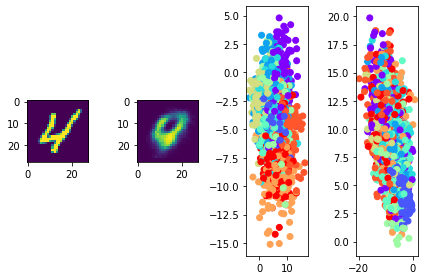

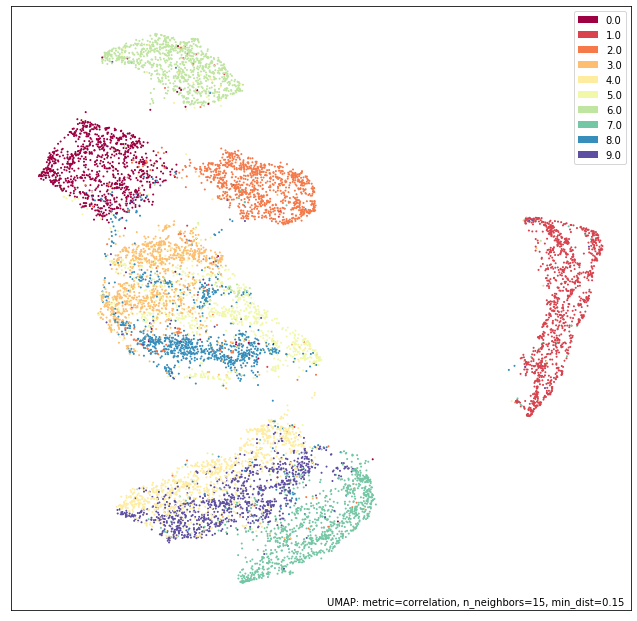

In [28]:
net_pca = train(PCA, 16)
X_pca, y_pca = test(net_pca)
mapper = umap.UMAP(n_neighbors=15, n_components=2, metric='correlation', min_dist=0.15).fit(X_pca)
umap.plot.points(mapper, labels=y_pca)

0 tensor(0.2551, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
1 tensor(0.2309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
2 tensor(0.1806, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
3 tensor(0.1887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
4 tensor(0.1669, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
5 tensor(0.1659, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
6 tensor(0.1533, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
7 tensor(0.1579, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
8 tensor(0.1566, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
9 tensor(0.1668, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
10 tensor(0.1494, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
11 tensor(0.1583, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
12 tensor(0.1364, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
13 tensor(0.1477, device='cuda:0', grad_fn=<BinaryCrossEntrop

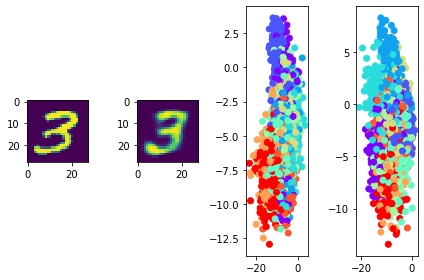

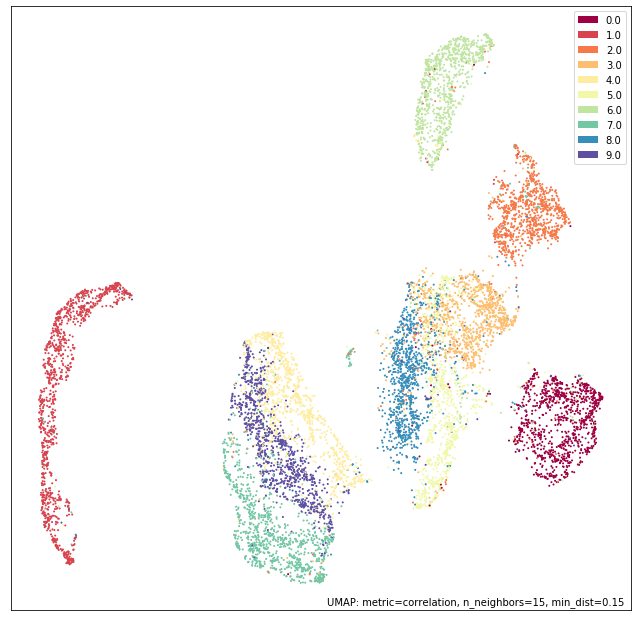

In [29]:
net_auto = train(AutoEncoder, 16)
X_auto, y_auto = test(net_auto)
mapper = umap.UMAP(n_neighbors=15, n_components=2, metric='correlation', min_dist=0.15).fit(X_auto)
umap.plot.points(mapper, labels=y_auto)

0 tensor(0.2533, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
1 tensor(0.2042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
2 tensor(0.2001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
3 tensor(0.1754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
4 tensor(0.1657, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
5 tensor(0.1535, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
6 tensor(0.1534, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
7 tensor(0.1383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
8 tensor(0.1485, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
9 tensor(0.1507, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
10 tensor(0.1344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
11 tensor(0.1365, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
12 tensor(0.1288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
13 tensor(0.1237, device='cuda:0', grad_fn=<BinaryCrossEntrop

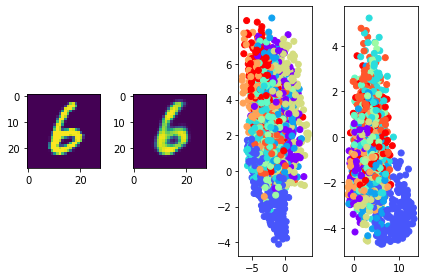

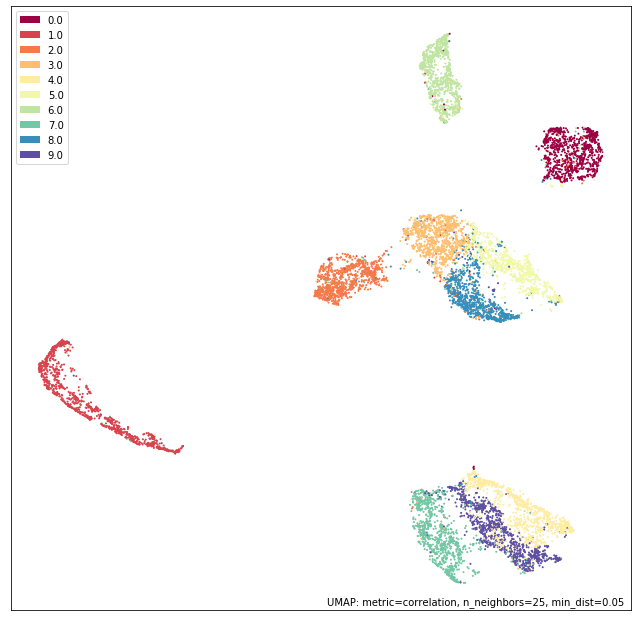

In [37]:
net_conv = train(AutoEncoder, 64)
X_conv, y_conv = test(net_conv)
mapper = umap.UMAP(n_neighbors=25, n_components=2, metric='correlation', min_dist=0.05).fit(X_conv)
umap.plot.points(mapper, labels=y_conv)